In [1]:
import sys
import SimpleITK as sitk
import matplotlib.pyplot as plt
%matplotlib inline 
import numpy as np
import os
import fnmatch
import shutil
from ipywidgets import interact, fixed
import pandas as pd
from pathlib import Path

#function for showing volume images
def myshow(image_arr,slice_n):
    plt.imshow(image_arr[slice_n,:,:],cmap='gray')
    plt.show()

In [2]:
data = pd.read_csv('C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/survival_data.csv')
data.head(10)

,BraTS18ID,Age,Survival,ResectionStatus
0,Brats18_TCIA08_167_1,74.907,153,NaN
1,Brats18_TCIA08_242_1,66.479,147,NaN
2,Brats18_TCIA08_319_1,64.860,254,NaN
3,Brats18_TCIA08_469_1,63.899,519,NaN
4,Brats18_TCIA08_218_1,57.345,346,NaN
5,Brats18_TCIA08_406_1,78.745,82,NaN
6,Brats18_TCIA08_280_1,57.362,508,NaN
7,Brats18_TCIA08_105_1,66.627,77,NaN
8,Brats18_TCIA08_278_1,50.501,1458,NaN
9,Brats18_TCIA06_247_1,76.699,244,NaN


In [5]:
#making separate directories for different modalities in order
path = 'C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/'
path_HGG = 'C://Image Processing/brats data/new/HGG/'
path_LGG = 'C://Image Processing/brats data/new/LGG/'
list_of_dirs = ['t1','T1Gd','t2','flair']

def make_my_dirs(directory, names):
    for i in names: 
        os.makedirs(directory+i, exist_ok = True)

make_my_dirs(path_HGG, list_of_dirs)
make_my_dirs(path_LGG, list_of_dirs)

In [3]:
#creating lists with images of different modalities

common_list = []
t2_list = []
t1_list = []
t1ce_list = []
flair_list = []
seg_list = []
for (dirpath, dirnames, filenames) in os.walk('C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/'):
    for filename in filenames: 
        if filename.endswith('.csv')==False and 'seg' not in filename.split('.')[0]:
            common_list.append(os.path.join(dirpath,filename))
            if 't2' in filename.split('.')[0]: 
                t2_list.append(os.path.join(dirpath,filename))
            if 't1' in filename.split('.')[0] and 't1ce' not in filename.split('.')[0]:
                t1_list.append(os.path.join(dirpath,filename))
            if 't1ce' in filename.split('.')[0]:
                t1ce_list.append(os.path.join(dirpath,filename))
            if 'flair' in filename.split('.')[0]:
                flair_list.append(os.path.join(dirpath,filename))
        if 'seg' in filename.split('.')[0]:
            seg_list.append(os.path.join(dirpath,filename))

In [4]:
#All of Modalities` paths into one dataframe for further processing

paths_data=pd.DataFrame(np.column_stack([t1_list,t1ce_list,t2_list,flair_list,seg_list]),
                       columns=['t1_p','t1ce_p','t2_p','flair_p','seg_p'])

pd.set_option('display.max_colwidth', -1)
paths_data.loc[222,:]

t1_p       C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/LGG\Brats18_TCIA09_254_1\Brats18_TCIA09_254_1_t1.nii.gz   
t1ce_p     C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/LGG\Brats18_TCIA09_254_1\Brats18_TCIA09_254_1_t1ce.nii.gz 
t2_p       C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/LGG\Brats18_TCIA09_254_1\Brats18_TCIA09_254_1_t2.nii.gz   
flair_p    C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/LGG\Brats18_TCIA09_254_1\Brats18_TCIA09_254_1_flair.nii.gz
seg_p      C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/LGG\Brats18_TCIA09_254_1\Brats18_TCIA09_254_1_seg.nii.gz  
Name: 222, dtype: object

In [12]:
len(t1_list)


285

In [5]:
def plot_spacing(l):
    ''' 

    this function helps to plot spacing histograms 
    
    l = list with files` paths 


    '''    
    temp_list=[]
    
    for image in l:
        image_read=sitk.ReadImage(image)
        value=list(image_read.GetSpacing())
        value = [round(i,2) for i in value ]
        temp_list.append((str(value)).strip('[]'))

    
    temp_df=pd.DataFrame(temp_list)
    
    
    plt.figure(figsize=(12,7))
    plt.suptitle('Pixel Spacing (x,y,z)',fontsize=20)
    ax=temp_df[0].value_counts().plot(kind='bar')
    ax.set_xlabel('pixel spacing (x,y,z) in mm',fontsize='large')
    ax.set_ylabel('patients count',fontsize='large')
    plt.show()



def plot_size(l):
    '''
    this function helps to plot size histograms 
    
    l = list with files` paths
    '''
    temp_list=[]
    
    for image in l:
        image_read=sitk.ReadImage(image)
        value=list(image_read.GetSize())
        value = [round(i,2) for i in value ]
        temp_list.append((str(value)).strip('[]'))

    
    temp_df=pd.DataFrame(temp_list)
    
    
    plt.figure(figsize=(12,7))
    plt.suptitle('Size',fontsize=20)
    ax=temp_df[0].value_counts().plot(kind='bar')
    ax.set_xlabel('Size ',fontsize='large')
    ax.set_ylabel('patients count',fontsize='large')
    plt.show()

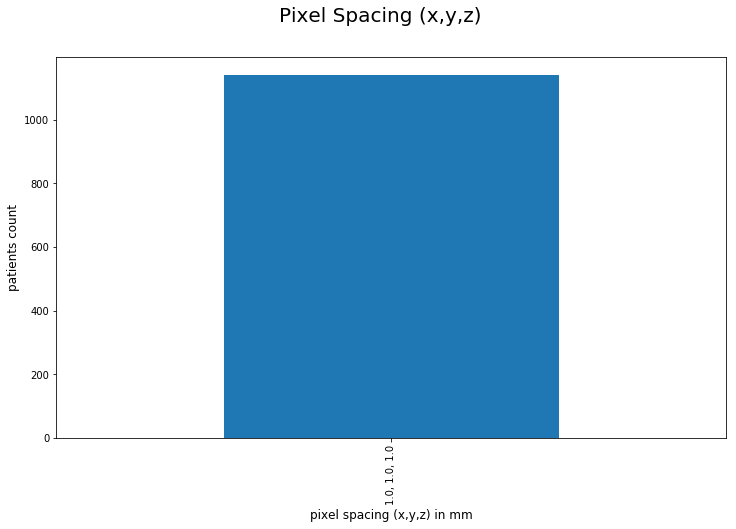

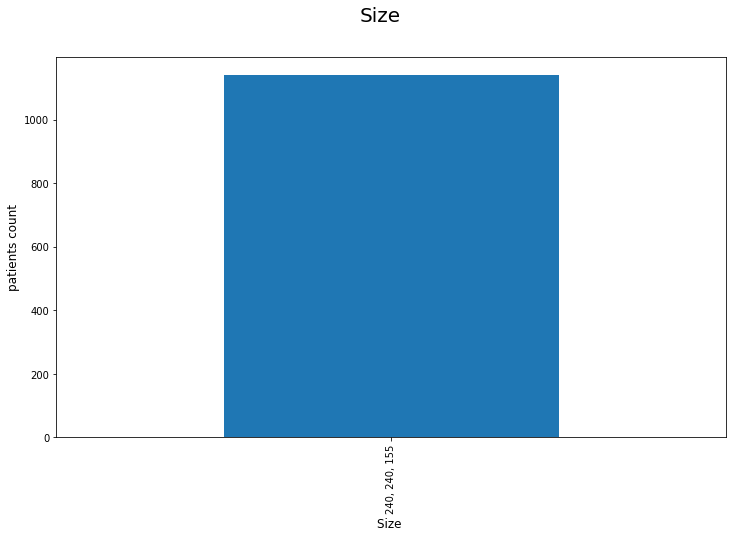

In [6]:
plot_spacing(common_list)
plot_size(common_list)

In [7]:
#For further processing we should plot Intensity Ranges
#Necessary because if it is differ we should normilize them

def plot_intensities(l,how='counts'):
    #plot intensity ranges 
    
    #l= path for the images
    
    #'counts' = plots all intensity ranges among all images
    #'min/max' = plots min and max values among all images
    mm = sitk.MinimumMaximumImageFilter() #takes minimum and maximum intensity values from image
    temp_list_counts = []
    min_max_list = []
    
    def getMinMax(img):
        #Function that takes minimum and maximum value from one image
        mm = sitk.MinimumMaximumImageFilter()
        mm.Execute(img)
        return (mm.GetMinimum(), mm.GetMaximum())
    
    for image in l:
        image_read=sitk.ReadImage(image)
        value = getMinMax(image_read)
        temp_list_counts.append(str(value).strip('()'))
        for i in value:
            min_max_list.append(i)
    temp_df_counts=pd.DataFrame(temp_list_counts)
    
    if how=='counts':
    
        plt.figure(figsize=(12,7))
        plt.suptitle('Intensity Range', fontsize=20)
        ax=temp_df_counts[0].value_counts().plot(kind='bar')
        ax.set_xlabel('Intensities', fontsize='large')
        ax.set_ylabel('Counts',fontsize='large')
        plt.show()
    
    if how=='min/max':
        print('the minimum intesity value is:\t{}\nthe maximum intensity value is:\t{}'.format(min(min_max_list), max(min_max_list)))

In [9]:
#Checking Intensities before normalization 

#Intensity Ranges among all images

plot_intensities(common_list, how='min/max')

the minimum intesity value is:	0.0
the maximum intensity value is:	32767.0


In [ ]:
#Plotting Intensities Ranges

plot_intensities(common_list)

# Normalization to [-127,127] scale range 

In [ ]:
sitk.WriteImage(img, os.path.join(OUTPUT_DIR, 'SimpleITK.png'))

In [169]:
#Linear Function Normalization

def norm_all(l):
    #set intensity scale to the range of [-127,127]
    imadjust = sitk.RescaleIntensityImageFilter()
    imadjust.SetOutputMinimum( -127 )
    imadjust.SetOutputMaximum( 127 )    
    for image in l: 
        im=sitk.ReadImage(image)
        print(image, '\tread')
        norm_im=imadjust.Execute( im )
        print(image, '\tnormalized')
        name =  image.split('\\')[-1]
        sitk.WriteImage(norm_im, name, True)
        print('{} normalized and written to directory'.format(name))

            
        
norm_all(common_list) #applying         

C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_2013_10_1\Brats18_2013_10_1_flair.nii.gz 	read
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_2013_10_1\Brats18_2013_10_1_flair.nii.gz 	normalized
Brats18_2013_10_1_flair.nii.gz normalized and written to directory
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_2013_10_1\Brats18_2013_10_1_t1.nii.gz 	read
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_2013_10_1\Brats18_2013_10_1_t1.nii.gz 	normalized
Brats18_2013_10_1_t1.nii.gz normalized and written to directory
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_2013_10_1\Brats18_2013_10_1_t1ce.nii.gz 	read
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_2013_10_1\Brats18_2013_10_1_t1ce.nii.gz 	normalized
Brats18_2013_10_1_t1ce.nii.gz normalized and written to directory
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_

C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_2013_18_1\Brats18_2013_18_1_t1ce.nii.gz 	normalized
Brats18_2013_18_1_t1ce.nii.gz normalized and written to directory
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_2013_18_1\Brats18_2013_18_1_t2.nii.gz 	read
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_2013_18_1\Brats18_2013_18_1_t2.nii.gz 	normalized
Brats18_2013_18_1_t2.nii.gz normalized and written to directory
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_2013_19_1\Brats18_2013_19_1_flair.nii.gz 	read
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_2013_19_1\Brats18_2013_19_1_flair.nii.gz 	normalized
Brats18_2013_19_1_flair.nii.gz normalized and written to directory
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_2013_19_1\Brats18_2013_19_1_t1.nii.gz 	read
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Tr

Brats18_2013_26_1_flair.nii.gz normalized and written to directory
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_2013_26_1\Brats18_2013_26_1_t1.nii.gz 	read
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_2013_26_1\Brats18_2013_26_1_t1.nii.gz 	normalized
Brats18_2013_26_1_t1.nii.gz normalized and written to directory
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_2013_26_1\Brats18_2013_26_1_t1ce.nii.gz 	read
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_2013_26_1\Brats18_2013_26_1_t1ce.nii.gz 	normalized
Brats18_2013_26_1_t1ce.nii.gz normalized and written to directory
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_2013_26_1\Brats18_2013_26_1_t2.nii.gz 	read
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_2013_26_1\Brats18_2013_26_1_t2.nii.gz 	normalized
Brats18_2013_26_1_t2.nii.gz normalized and written to directo

Brats18_2013_7_1_t2.nii.gz normalized and written to directory
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_CBICA_AAB_1\Brats18_CBICA_AAB_1_flair.nii.gz 	read
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_CBICA_AAB_1\Brats18_CBICA_AAB_1_flair.nii.gz 	normalized
Brats18_CBICA_AAB_1_flair.nii.gz normalized and written to directory
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_CBICA_AAB_1\Brats18_CBICA_AAB_1_t1.nii.gz 	read
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_CBICA_AAB_1\Brats18_CBICA_AAB_1_t1.nii.gz 	normalized
Brats18_CBICA_AAB_1_t1.nii.gz normalized and written to directory
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_CBICA_AAB_1\Brats18_CBICA_AAB_1_t1ce.nii.gz 	read
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_CBICA_AAB_1\Brats18_CBICA_AAB_1_t1ce.nii.gz 	normalized
Brats18_CBICA_AAB_1_t1ce.nii.g

C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_CBICA_ABM_1\Brats18_CBICA_ABM_1_t1.nii.gz 	normalized
Brats18_CBICA_ABM_1_t1.nii.gz normalized and written to directory
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_CBICA_ABM_1\Brats18_CBICA_ABM_1_t1ce.nii.gz 	read
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_CBICA_ABM_1\Brats18_CBICA_ABM_1_t1ce.nii.gz 	normalized
Brats18_CBICA_ABM_1_t1ce.nii.gz normalized and written to directory
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_CBICA_ABM_1\Brats18_CBICA_ABM_1_t2.nii.gz 	read
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_CBICA_ABM_1\Brats18_CBICA_ABM_1_t2.nii.gz 	normalized
Brats18_CBICA_ABM_1_t2.nii.gz normalized and written to directory
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_CBICA_ABN_1\Brats18_CBICA_ABN_1_flair.nii.gz 	read
C://Image Processing/brats data

Brats18_CBICA_ALX_1_t1ce.nii.gz normalized and written to directory
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_CBICA_ALX_1\Brats18_CBICA_ALX_1_t2.nii.gz 	read
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_CBICA_ALX_1\Brats18_CBICA_ALX_1_t2.nii.gz 	normalized
Brats18_CBICA_ALX_1_t2.nii.gz normalized and written to directory
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_CBICA_AME_1\Brats18_CBICA_AME_1_flair.nii.gz 	read
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_CBICA_AME_1\Brats18_CBICA_AME_1_flair.nii.gz 	normalized
Brats18_CBICA_AME_1_flair.nii.gz normalized and written to directory
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_CBICA_AME_1\Brats18_CBICA_AME_1_t1.nii.gz 	read
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_CBICA_AME_1\Brats18_CBICA_AME_1_t1.nii.gz 	normalized
Brats18_CBICA_AME_1_t1.nii.gz

Brats18_CBICA_AOD_1_flair.nii.gz normalized and written to directory
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_CBICA_AOD_1\Brats18_CBICA_AOD_1_t1.nii.gz 	read
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_CBICA_AOD_1\Brats18_CBICA_AOD_1_t1.nii.gz 	normalized
Brats18_CBICA_AOD_1_t1.nii.gz normalized and written to directory
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_CBICA_AOD_1\Brats18_CBICA_AOD_1_t1ce.nii.gz 	read
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_CBICA_AOD_1\Brats18_CBICA_AOD_1_t1ce.nii.gz 	normalized
Brats18_CBICA_AOD_1_t1ce.nii.gz normalized and written to directory
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_CBICA_AOD_1\Brats18_CBICA_AOD_1_t2.nii.gz 	read
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_CBICA_AOD_1\Brats18_CBICA_AOD_1_t2.nii.gz 	normalized
Brats18_CBICA_AOD_1_t2.nii.gz n

Brats18_CBICA_APY_1_t1ce.nii.gz normalized and written to directory
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_CBICA_APY_1\Brats18_CBICA_APY_1_t2.nii.gz 	read
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_CBICA_APY_1\Brats18_CBICA_APY_1_t2.nii.gz 	normalized
Brats18_CBICA_APY_1_t2.nii.gz normalized and written to directory
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_CBICA_APZ_1\Brats18_CBICA_APZ_1_flair.nii.gz 	read
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_CBICA_APZ_1\Brats18_CBICA_APZ_1_flair.nii.gz 	normalized
Brats18_CBICA_APZ_1_flair.nii.gz normalized and written to directory
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_CBICA_APZ_1\Brats18_CBICA_APZ_1_t1.nii.gz 	read
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_CBICA_APZ_1\Brats18_CBICA_APZ_1_t1.nii.gz 	normalized
Brats18_CBICA_APZ_1_t1.nii.gz

Brats18_CBICA_AQO_1_flair.nii.gz normalized and written to directory
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_CBICA_AQO_1\Brats18_CBICA_AQO_1_t1.nii.gz 	read
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_CBICA_AQO_1\Brats18_CBICA_AQO_1_t1.nii.gz 	normalized
Brats18_CBICA_AQO_1_t1.nii.gz normalized and written to directory
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_CBICA_AQO_1\Brats18_CBICA_AQO_1_t1ce.nii.gz 	read
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_CBICA_AQO_1\Brats18_CBICA_AQO_1_t1ce.nii.gz 	normalized
Brats18_CBICA_AQO_1_t1ce.nii.gz normalized and written to directory
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_CBICA_AQO_1\Brats18_CBICA_AQO_1_t2.nii.gz 	read
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_CBICA_AQO_1\Brats18_CBICA_AQO_1_t2.nii.gz 	normalized
Brats18_CBICA_AQO_1_t2.nii.gz n

Brats18_CBICA_AQV_1_t1ce.nii.gz normalized and written to directory
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_CBICA_AQV_1\Brats18_CBICA_AQV_1_t2.nii.gz 	read
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_CBICA_AQV_1\Brats18_CBICA_AQV_1_t2.nii.gz 	normalized
Brats18_CBICA_AQV_1_t2.nii.gz normalized and written to directory
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_CBICA_AQY_1\Brats18_CBICA_AQY_1_flair.nii.gz 	read
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_CBICA_AQY_1\Brats18_CBICA_AQY_1_flair.nii.gz 	normalized
Brats18_CBICA_AQY_1_flair.nii.gz normalized and written to directory
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_CBICA_AQY_1\Brats18_CBICA_AQY_1_t1.nii.gz 	read
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_CBICA_AQY_1\Brats18_CBICA_AQY_1_t1.nii.gz 	normalized
Brats18_CBICA_AQY_1_t1.nii.gz

Brats18_CBICA_ASE_1_flair.nii.gz normalized and written to directory
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_CBICA_ASE_1\Brats18_CBICA_ASE_1_t1.nii.gz 	read
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_CBICA_ASE_1\Brats18_CBICA_ASE_1_t1.nii.gz 	normalized
Brats18_CBICA_ASE_1_t1.nii.gz normalized and written to directory
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_CBICA_ASE_1\Brats18_CBICA_ASE_1_t1ce.nii.gz 	read
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_CBICA_ASE_1\Brats18_CBICA_ASE_1_t1ce.nii.gz 	normalized
Brats18_CBICA_ASE_1_t1ce.nii.gz normalized and written to directory
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_CBICA_ASE_1\Brats18_CBICA_ASE_1_t2.nii.gz 	read
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_CBICA_ASE_1\Brats18_CBICA_ASE_1_t2.nii.gz 	normalized
Brats18_CBICA_ASE_1_t2.nii.gz n

Brats18_CBICA_ASU_1_t1ce.nii.gz normalized and written to directory
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_CBICA_ASU_1\Brats18_CBICA_ASU_1_t2.nii.gz 	read
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_CBICA_ASU_1\Brats18_CBICA_ASU_1_t2.nii.gz 	normalized
Brats18_CBICA_ASU_1_t2.nii.gz normalized and written to directory
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_CBICA_ASV_1\Brats18_CBICA_ASV_1_flair.nii.gz 	read
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_CBICA_ASV_1\Brats18_CBICA_ASV_1_flair.nii.gz 	normalized
Brats18_CBICA_ASV_1_flair.nii.gz normalized and written to directory
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_CBICA_ASV_1\Brats18_CBICA_ASV_1_t1.nii.gz 	read
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_CBICA_ASV_1\Brats18_CBICA_ASV_1_t1.nii.gz 	normalized
Brats18_CBICA_ASV_1_t1.nii.gz

Brats18_CBICA_ATP_1_flair.nii.gz normalized and written to directory
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_CBICA_ATP_1\Brats18_CBICA_ATP_1_t1.nii.gz 	read
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_CBICA_ATP_1\Brats18_CBICA_ATP_1_t1.nii.gz 	normalized
Brats18_CBICA_ATP_1_t1.nii.gz normalized and written to directory
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_CBICA_ATP_1\Brats18_CBICA_ATP_1_t1ce.nii.gz 	read
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_CBICA_ATP_1\Brats18_CBICA_ATP_1_t1ce.nii.gz 	normalized
Brats18_CBICA_ATP_1_t1ce.nii.gz normalized and written to directory
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_CBICA_ATP_1\Brats18_CBICA_ATP_1_t2.nii.gz 	read
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_CBICA_ATP_1\Brats18_CBICA_ATP_1_t2.nii.gz 	normalized
Brats18_CBICA_ATP_1_t2.nii.gz n

Brats18_CBICA_AVG_1_t1ce.nii.gz normalized and written to directory
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_CBICA_AVG_1\Brats18_CBICA_AVG_1_t2.nii.gz 	read
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_CBICA_AVG_1\Brats18_CBICA_AVG_1_t2.nii.gz 	normalized
Brats18_CBICA_AVG_1_t2.nii.gz normalized and written to directory
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_CBICA_AVJ_1\Brats18_CBICA_AVJ_1_flair.nii.gz 	read
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_CBICA_AVJ_1\Brats18_CBICA_AVJ_1_flair.nii.gz 	normalized
Brats18_CBICA_AVJ_1_flair.nii.gz normalized and written to directory
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_CBICA_AVJ_1\Brats18_CBICA_AVJ_1_t1.nii.gz 	read
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_CBICA_AVJ_1\Brats18_CBICA_AVJ_1_t1.nii.gz 	normalized
Brats18_CBICA_AVJ_1_t1.nii.gz

Brats18_CBICA_AXL_1_flair.nii.gz normalized and written to directory
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_CBICA_AXL_1\Brats18_CBICA_AXL_1_t1.nii.gz 	read
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_CBICA_AXL_1\Brats18_CBICA_AXL_1_t1.nii.gz 	normalized
Brats18_CBICA_AXL_1_t1.nii.gz normalized and written to directory
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_CBICA_AXL_1\Brats18_CBICA_AXL_1_t1ce.nii.gz 	read
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_CBICA_AXL_1\Brats18_CBICA_AXL_1_t1ce.nii.gz 	normalized
Brats18_CBICA_AXL_1_t1ce.nii.gz normalized and written to directory
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_CBICA_AXL_1\Brats18_CBICA_AXL_1_t2.nii.gz 	read
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_CBICA_AXL_1\Brats18_CBICA_AXL_1_t2.nii.gz 	normalized
Brats18_CBICA_AXL_1_t2.nii.gz n

Brats18_CBICA_AYA_1_t1ce.nii.gz normalized and written to directory
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_CBICA_AYA_1\Brats18_CBICA_AYA_1_t2.nii.gz 	read
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_CBICA_AYA_1\Brats18_CBICA_AYA_1_t2.nii.gz 	normalized
Brats18_CBICA_AYA_1_t2.nii.gz normalized and written to directory
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_CBICA_AYI_1\Brats18_CBICA_AYI_1_flair.nii.gz 	read
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_CBICA_AYI_1\Brats18_CBICA_AYI_1_flair.nii.gz 	normalized
Brats18_CBICA_AYI_1_flair.nii.gz normalized and written to directory
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_CBICA_AYI_1\Brats18_CBICA_AYI_1_t1.nii.gz 	read
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_CBICA_AYI_1\Brats18_CBICA_AYI_1_t1.nii.gz 	normalized
Brats18_CBICA_AYI_1_t1.nii.gz

Brats18_CBICA_BFP_1_flair.nii.gz normalized and written to directory
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_CBICA_BFP_1\Brats18_CBICA_BFP_1_t1.nii.gz 	read
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_CBICA_BFP_1\Brats18_CBICA_BFP_1_t1.nii.gz 	normalized
Brats18_CBICA_BFP_1_t1.nii.gz normalized and written to directory
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_CBICA_BFP_1\Brats18_CBICA_BFP_1_t1ce.nii.gz 	read
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_CBICA_BFP_1\Brats18_CBICA_BFP_1_t1ce.nii.gz 	normalized
Brats18_CBICA_BFP_1_t1ce.nii.gz normalized and written to directory
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_CBICA_BFP_1\Brats18_CBICA_BFP_1_t2.nii.gz 	read
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_CBICA_BFP_1\Brats18_CBICA_BFP_1_t2.nii.gz 	normalized
Brats18_CBICA_BFP_1_t2.nii.gz n

C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_TCIA01_150_1\Brats18_TCIA01_150_1_t1ce.nii.gz 	read
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_TCIA01_150_1\Brats18_TCIA01_150_1_t1ce.nii.gz 	normalized
Brats18_TCIA01_150_1_t1ce.nii.gz normalized and written to directory
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_TCIA01_150_1\Brats18_TCIA01_150_1_t2.nii.gz 	read
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_TCIA01_150_1\Brats18_TCIA01_150_1_t2.nii.gz 	normalized
Brats18_TCIA01_150_1_t2.nii.gz normalized and written to directory
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_TCIA01_180_1\Brats18_TCIA01_180_1_flair.nii.gz 	read
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_TCIA01_180_1\Brats18_TCIA01_180_1_flair.nii.gz 	normalized
Brats18_TCIA01_180_1_flair.nii.gz normalized and written to directory
C://Image 

C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_TCIA01_221_1\Brats18_TCIA01_221_1_t2.nii.gz 	read
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_TCIA01_221_1\Brats18_TCIA01_221_1_t2.nii.gz 	normalized
Brats18_TCIA01_221_1_t2.nii.gz normalized and written to directory
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_TCIA01_231_1\Brats18_TCIA01_231_1_flair.nii.gz 	read
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_TCIA01_231_1\Brats18_TCIA01_231_1_flair.nii.gz 	normalized
Brats18_TCIA01_231_1_flair.nii.gz normalized and written to directory
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_TCIA01_231_1\Brats18_TCIA01_231_1_t1.nii.gz 	read
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_TCIA01_231_1\Brats18_TCIA01_231_1_t1.nii.gz 	normalized
Brats18_TCIA01_231_1_t1.nii.gz normalized and written to directory
C://Image Proces

C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_TCIA01_411_1\Brats18_TCIA01_411_1_flair.nii.gz 	read
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_TCIA01_411_1\Brats18_TCIA01_411_1_flair.nii.gz 	normalized
Brats18_TCIA01_411_1_flair.nii.gz normalized and written to directory
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_TCIA01_411_1\Brats18_TCIA01_411_1_t1.nii.gz 	read
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_TCIA01_411_1\Brats18_TCIA01_411_1_t1.nii.gz 	normalized
Brats18_TCIA01_411_1_t1.nii.gz normalized and written to directory
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_TCIA01_411_1\Brats18_TCIA01_411_1_t1ce.nii.gz 	read
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_TCIA01_411_1\Brats18_TCIA01_411_1_t1ce.nii.gz 	normalized
Brats18_TCIA01_411_1_t1ce.nii.gz normalized and written to directory
C://Image 

C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_TCIA01_499_1\Brats18_TCIA01_499_1_t1.nii.gz 	read
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_TCIA01_499_1\Brats18_TCIA01_499_1_t1.nii.gz 	normalized
Brats18_TCIA01_499_1_t1.nii.gz normalized and written to directory
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_TCIA01_499_1\Brats18_TCIA01_499_1_t1ce.nii.gz 	read
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_TCIA01_499_1\Brats18_TCIA01_499_1_t1ce.nii.gz 	normalized
Brats18_TCIA01_499_1_t1ce.nii.gz normalized and written to directory
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_TCIA01_499_1\Brats18_TCIA01_499_1_t2.nii.gz 	read
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_TCIA01_499_1\Brats18_TCIA01_499_1_t2.nii.gz 	normalized
Brats18_TCIA01_499_1_t2.nii.gz normalized and written to directory
C://Image Processin

C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_TCIA02_171_1\Brats18_TCIA02_171_1_t1ce.nii.gz 	read
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_TCIA02_171_1\Brats18_TCIA02_171_1_t1ce.nii.gz 	normalized
Brats18_TCIA02_171_1_t1ce.nii.gz normalized and written to directory
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_TCIA02_171_1\Brats18_TCIA02_171_1_t2.nii.gz 	read
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_TCIA02_171_1\Brats18_TCIA02_171_1_t2.nii.gz 	normalized
Brats18_TCIA02_171_1_t2.nii.gz normalized and written to directory
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_TCIA02_179_1\Brats18_TCIA02_179_1_flair.nii.gz 	read
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_TCIA02_179_1\Brats18_TCIA02_179_1_flair.nii.gz 	normalized
Brats18_TCIA02_179_1_flair.nii.gz normalized and written to directory
C://Image 

C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_TCIA02_274_1\Brats18_TCIA02_274_1_t2.nii.gz 	read
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_TCIA02_274_1\Brats18_TCIA02_274_1_t2.nii.gz 	normalized
Brats18_TCIA02_274_1_t2.nii.gz normalized and written to directory
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_TCIA02_283_1\Brats18_TCIA02_283_1_flair.nii.gz 	read
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_TCIA02_283_1\Brats18_TCIA02_283_1_flair.nii.gz 	normalized
Brats18_TCIA02_283_1_flair.nii.gz normalized and written to directory
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_TCIA02_283_1\Brats18_TCIA02_283_1_t1.nii.gz 	read
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_TCIA02_283_1\Brats18_TCIA02_283_1_t1.nii.gz 	normalized
Brats18_TCIA02_283_1_t1.nii.gz normalized and written to directory
C://Image Proces

C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_TCIA02_322_1\Brats18_TCIA02_322_1_flair.nii.gz 	read
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_TCIA02_322_1\Brats18_TCIA02_322_1_flair.nii.gz 	normalized
Brats18_TCIA02_322_1_flair.nii.gz normalized and written to directory
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_TCIA02_322_1\Brats18_TCIA02_322_1_t1.nii.gz 	read
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_TCIA02_322_1\Brats18_TCIA02_322_1_t1.nii.gz 	normalized
Brats18_TCIA02_322_1_t1.nii.gz normalized and written to directory
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_TCIA02_322_1\Brats18_TCIA02_322_1_t1ce.nii.gz 	read
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_TCIA02_322_1\Brats18_TCIA02_322_1_t1ce.nii.gz 	normalized
Brats18_TCIA02_322_1_t1ce.nii.gz normalized and written to directory
C://Image 

C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_TCIA02_394_1\Brats18_TCIA02_394_1_t1.nii.gz 	read
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_TCIA02_394_1\Brats18_TCIA02_394_1_t1.nii.gz 	normalized
Brats18_TCIA02_394_1_t1.nii.gz normalized and written to directory
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_TCIA02_394_1\Brats18_TCIA02_394_1_t1ce.nii.gz 	read
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_TCIA02_394_1\Brats18_TCIA02_394_1_t1ce.nii.gz 	normalized
Brats18_TCIA02_394_1_t1ce.nii.gz normalized and written to directory
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_TCIA02_394_1\Brats18_TCIA02_394_1_t2.nii.gz 	read
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_TCIA02_394_1\Brats18_TCIA02_394_1_t2.nii.gz 	normalized
Brats18_TCIA02_394_1_t2.nii.gz normalized and written to directory
C://Image Processin

C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_TCIA02_605_1\Brats18_TCIA02_605_1_t1ce.nii.gz 	read
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_TCIA02_605_1\Brats18_TCIA02_605_1_t1ce.nii.gz 	normalized
Brats18_TCIA02_605_1_t1ce.nii.gz normalized and written to directory
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_TCIA02_605_1\Brats18_TCIA02_605_1_t2.nii.gz 	read
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_TCIA02_605_1\Brats18_TCIA02_605_1_t2.nii.gz 	normalized
Brats18_TCIA02_605_1_t2.nii.gz normalized and written to directory
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_TCIA02_606_1\Brats18_TCIA02_606_1_flair.nii.gz 	read
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_TCIA02_606_1\Brats18_TCIA02_606_1_flair.nii.gz 	normalized
Brats18_TCIA02_606_1_flair.nii.gz normalized and written to directory
C://Image 

C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_TCIA03_138_1\Brats18_TCIA03_138_1_t2.nii.gz 	read
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_TCIA03_138_1\Brats18_TCIA03_138_1_t2.nii.gz 	normalized
Brats18_TCIA03_138_1_t2.nii.gz normalized and written to directory
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_TCIA03_199_1\Brats18_TCIA03_199_1_flair.nii.gz 	read
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_TCIA03_199_1\Brats18_TCIA03_199_1_flair.nii.gz 	normalized
Brats18_TCIA03_199_1_flair.nii.gz normalized and written to directory
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_TCIA03_199_1\Brats18_TCIA03_199_1_t1.nii.gz 	read
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_TCIA03_199_1\Brats18_TCIA03_199_1_t1.nii.gz 	normalized
Brats18_TCIA03_199_1_t1.nii.gz normalized and written to directory
C://Image Proces

C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_TCIA03_419_1\Brats18_TCIA03_419_1_flair.nii.gz 	read
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_TCIA03_419_1\Brats18_TCIA03_419_1_flair.nii.gz 	normalized
Brats18_TCIA03_419_1_flair.nii.gz normalized and written to directory
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_TCIA03_419_1\Brats18_TCIA03_419_1_t1.nii.gz 	read
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_TCIA03_419_1\Brats18_TCIA03_419_1_t1.nii.gz 	normalized
Brats18_TCIA03_419_1_t1.nii.gz normalized and written to directory
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_TCIA03_419_1\Brats18_TCIA03_419_1_t1ce.nii.gz 	read
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_TCIA03_419_1\Brats18_TCIA03_419_1_t1ce.nii.gz 	normalized
Brats18_TCIA03_419_1_t1ce.nii.gz normalized and written to directory
C://Image 

C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_TCIA04_328_1\Brats18_TCIA04_328_1_t1.nii.gz 	read
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_TCIA04_328_1\Brats18_TCIA04_328_1_t1.nii.gz 	normalized
Brats18_TCIA04_328_1_t1.nii.gz normalized and written to directory
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_TCIA04_328_1\Brats18_TCIA04_328_1_t1ce.nii.gz 	read
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_TCIA04_328_1\Brats18_TCIA04_328_1_t1ce.nii.gz 	normalized
Brats18_TCIA04_328_1_t1ce.nii.gz normalized and written to directory
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_TCIA04_328_1\Brats18_TCIA04_328_1_t2.nii.gz 	read
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_TCIA04_328_1\Brats18_TCIA04_328_1_t2.nii.gz 	normalized
Brats18_TCIA04_328_1_t2.nii.gz normalized and written to directory
C://Image Processin

C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_TCIA05_396_1\Brats18_TCIA05_396_1_t1ce.nii.gz 	normalized
Brats18_TCIA05_396_1_t1ce.nii.gz normalized and written to directory
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_TCIA05_396_1\Brats18_TCIA05_396_1_t2.nii.gz 	read
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_TCIA05_396_1\Brats18_TCIA05_396_1_t2.nii.gz 	normalized
Brats18_TCIA05_396_1_t2.nii.gz normalized and written to directory
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_TCIA05_444_1\Brats18_TCIA05_444_1_flair.nii.gz 	read
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_TCIA05_444_1\Brats18_TCIA05_444_1_flair.nii.gz 	normalized
Brats18_TCIA05_444_1_flair.nii.gz normalized and written to directory
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_TCIA05_444_1\Brats18_TCIA05_444_1_t1.nii.gz 	read
C://Image Pr

Brats18_TCIA06_247_1_t2.nii.gz normalized and written to directory
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_TCIA06_332_1\Brats18_TCIA06_332_1_flair.nii.gz 	read
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_TCIA06_332_1\Brats18_TCIA06_332_1_flair.nii.gz 	normalized
Brats18_TCIA06_332_1_flair.nii.gz normalized and written to directory
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_TCIA06_332_1\Brats18_TCIA06_332_1_t1.nii.gz 	read
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_TCIA06_332_1\Brats18_TCIA06_332_1_t1.nii.gz 	normalized
Brats18_TCIA06_332_1_t1.nii.gz normalized and written to directory
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_TCIA06_332_1\Brats18_TCIA06_332_1_t1ce.nii.gz 	read
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_TCIA06_332_1\Brats18_TCIA06_332_1_t1ce.nii.gz 	normalized
Brats18_TCIA

Brats18_TCIA08_162_1_flair.nii.gz normalized and written to directory
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_TCIA08_162_1\Brats18_TCIA08_162_1_t1.nii.gz 	read
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_TCIA08_162_1\Brats18_TCIA08_162_1_t1.nii.gz 	normalized
Brats18_TCIA08_162_1_t1.nii.gz normalized and written to directory
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_TCIA08_162_1\Brats18_TCIA08_162_1_t1ce.nii.gz 	read
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_TCIA08_162_1\Brats18_TCIA08_162_1_t1ce.nii.gz 	normalized
Brats18_TCIA08_162_1_t1ce.nii.gz normalized and written to directory
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_TCIA08_162_1\Brats18_TCIA08_162_1_t2.nii.gz 	read
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_TCIA08_162_1\Brats18_TCIA08_162_1_t2.nii.gz 	normalized
Brats18_TCIA08_1

Brats18_TCIA08_278_1_t1.nii.gz normalized and written to directory
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_TCIA08_278_1\Brats18_TCIA08_278_1_t1ce.nii.gz 	read
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_TCIA08_278_1\Brats18_TCIA08_278_1_t1ce.nii.gz 	normalized
Brats18_TCIA08_278_1_t1ce.nii.gz normalized and written to directory
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_TCIA08_278_1\Brats18_TCIA08_278_1_t2.nii.gz 	read
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_TCIA08_278_1\Brats18_TCIA08_278_1_t2.nii.gz 	normalized
Brats18_TCIA08_278_1_t2.nii.gz normalized and written to directory
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_TCIA08_280_1\Brats18_TCIA08_280_1_flair.nii.gz 	read
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_TCIA08_280_1\Brats18_TCIA08_280_1_flair.nii.gz 	normalized
Brats18_TCIA0

C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/LGG\Brats18_2013_0_1\Brats18_2013_0_1_t2.nii.gz 	normalized
Brats18_2013_0_1_t2.nii.gz normalized and written to directory
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/LGG\Brats18_2013_15_1\Brats18_2013_15_1_flair.nii.gz 	read
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/LGG\Brats18_2013_15_1\Brats18_2013_15_1_flair.nii.gz 	normalized
Brats18_2013_15_1_flair.nii.gz normalized and written to directory
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/LGG\Brats18_2013_15_1\Brats18_2013_15_1_t1.nii.gz 	read
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/LGG\Brats18_2013_15_1\Brats18_2013_15_1_t1.nii.gz 	normalized
Brats18_2013_15_1_t1.nii.gz normalized and written to directory
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/LGG\Brats18_2013_15_1\Brats18_2013_15_1_t1ce.nii.gz 	read
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Trainin

Brats18_2013_6_1_t1.nii.gz normalized and written to directory
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/LGG\Brats18_2013_6_1\Brats18_2013_6_1_t1ce.nii.gz 	read
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/LGG\Brats18_2013_6_1\Brats18_2013_6_1_t1ce.nii.gz 	normalized
Brats18_2013_6_1_t1ce.nii.gz normalized and written to directory
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/LGG\Brats18_2013_6_1\Brats18_2013_6_1_t2.nii.gz 	read
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/LGG\Brats18_2013_6_1\Brats18_2013_6_1_t2.nii.gz 	normalized
Brats18_2013_6_1_t2.nii.gz normalized and written to directory
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/LGG\Brats18_2013_8_1\Brats18_2013_8_1_flair.nii.gz 	read
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/LGG\Brats18_2013_8_1\Brats18_2013_8_1_flair.nii.gz 	normalized
Brats18_2013_8_1_flair.nii.gz normalized and written to directory
C://Ima

Brats18_TCIA09_255_1_t2.nii.gz normalized and written to directory
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/LGG\Brats18_TCIA09_312_1\Brats18_TCIA09_312_1_flair.nii.gz 	read
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/LGG\Brats18_TCIA09_312_1\Brats18_TCIA09_312_1_flair.nii.gz 	normalized
Brats18_TCIA09_312_1_flair.nii.gz normalized and written to directory
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/LGG\Brats18_TCIA09_312_1\Brats18_TCIA09_312_1_t1.nii.gz 	read
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/LGG\Brats18_TCIA09_312_1\Brats18_TCIA09_312_1_t1.nii.gz 	normalized
Brats18_TCIA09_312_1_t1.nii.gz normalized and written to directory
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/LGG\Brats18_TCIA09_312_1\Brats18_TCIA09_312_1_t1ce.nii.gz 	read
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/LGG\Brats18_TCIA09_312_1\Brats18_TCIA09_312_1_t1ce.nii.gz 	normalized
Brats18_TCIA

Brats18_TCIA09_620_1_flair.nii.gz normalized and written to directory
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/LGG\Brats18_TCIA09_620_1\Brats18_TCIA09_620_1_t1.nii.gz 	read
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/LGG\Brats18_TCIA09_620_1\Brats18_TCIA09_620_1_t1.nii.gz 	normalized
Brats18_TCIA09_620_1_t1.nii.gz normalized and written to directory
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/LGG\Brats18_TCIA09_620_1\Brats18_TCIA09_620_1_t1ce.nii.gz 	read
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/LGG\Brats18_TCIA09_620_1\Brats18_TCIA09_620_1_t1ce.nii.gz 	normalized
Brats18_TCIA09_620_1_t1ce.nii.gz normalized and written to directory
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/LGG\Brats18_TCIA09_620_1\Brats18_TCIA09_620_1_t2.nii.gz 	read
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/LGG\Brats18_TCIA09_620_1\Brats18_TCIA09_620_1_t2.nii.gz 	normalized
Brats18_TCIA09_6

Brats18_TCIA10_202_1_t1.nii.gz normalized and written to directory
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/LGG\Brats18_TCIA10_202_1\Brats18_TCIA10_202_1_t1ce.nii.gz 	read
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/LGG\Brats18_TCIA10_202_1\Brats18_TCIA10_202_1_t1ce.nii.gz 	normalized
Brats18_TCIA10_202_1_t1ce.nii.gz normalized and written to directory
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/LGG\Brats18_TCIA10_202_1\Brats18_TCIA10_202_1_t2.nii.gz 	read
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/LGG\Brats18_TCIA10_202_1\Brats18_TCIA10_202_1_t2.nii.gz 	normalized
Brats18_TCIA10_202_1_t2.nii.gz normalized and written to directory
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/LGG\Brats18_TCIA10_241_1\Brats18_TCIA10_241_1_flair.nii.gz 	read
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/LGG\Brats18_TCIA10_241_1\Brats18_TCIA10_241_1_flair.nii.gz 	normalized
Brats18_TCIA1

Brats18_TCIA10_299_1_t1ce.nii.gz normalized and written to directory
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/LGG\Brats18_TCIA10_299_1\Brats18_TCIA10_299_1_t2.nii.gz 	read
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/LGG\Brats18_TCIA10_299_1\Brats18_TCIA10_299_1_t2.nii.gz 	normalized
Brats18_TCIA10_299_1_t2.nii.gz normalized and written to directory
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/LGG\Brats18_TCIA10_307_1\Brats18_TCIA10_307_1_flair.nii.gz 	read
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/LGG\Brats18_TCIA10_307_1\Brats18_TCIA10_307_1_flair.nii.gz 	normalized
Brats18_TCIA10_307_1_flair.nii.gz normalized and written to directory
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/LGG\Brats18_TCIA10_307_1\Brats18_TCIA10_307_1_t1.nii.gz 	read
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/LGG\Brats18_TCIA10_307_1\Brats18_TCIA10_307_1_t1.nii.gz 	normalized
Brats18_TCIA10

Brats18_TCIA10_351_1_t2.nii.gz normalized and written to directory
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/LGG\Brats18_TCIA10_387_1\Brats18_TCIA10_387_1_flair.nii.gz 	read
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/LGG\Brats18_TCIA10_387_1\Brats18_TCIA10_387_1_flair.nii.gz 	normalized
Brats18_TCIA10_387_1_flair.nii.gz normalized and written to directory
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/LGG\Brats18_TCIA10_387_1\Brats18_TCIA10_387_1_t1.nii.gz 	read
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/LGG\Brats18_TCIA10_387_1\Brats18_TCIA10_387_1_t1.nii.gz 	normalized
Brats18_TCIA10_387_1_t1.nii.gz normalized and written to directory
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/LGG\Brats18_TCIA10_387_1\Brats18_TCIA10_387_1_t1ce.nii.gz 	read
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/LGG\Brats18_TCIA10_387_1\Brats18_TCIA10_387_1_t1ce.nii.gz 	normalized
Brats18_TCIA

Brats18_TCIA10_442_1_flair.nii.gz normalized and written to directory
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/LGG\Brats18_TCIA10_442_1\Brats18_TCIA10_442_1_t1.nii.gz 	read
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/LGG\Brats18_TCIA10_442_1\Brats18_TCIA10_442_1_t1.nii.gz 	normalized
Brats18_TCIA10_442_1_t1.nii.gz normalized and written to directory
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/LGG\Brats18_TCIA10_442_1\Brats18_TCIA10_442_1_t1ce.nii.gz 	read
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/LGG\Brats18_TCIA10_442_1\Brats18_TCIA10_442_1_t1ce.nii.gz 	normalized
Brats18_TCIA10_442_1_t1ce.nii.gz normalized and written to directory
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/LGG\Brats18_TCIA10_442_1\Brats18_TCIA10_442_1_t2.nii.gz 	read
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/LGG\Brats18_TCIA10_442_1\Brats18_TCIA10_442_1_t2.nii.gz 	normalized
Brats18_TCIA10_4

Brats18_TCIA10_632_1_t1.nii.gz normalized and written to directory
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/LGG\Brats18_TCIA10_632_1\Brats18_TCIA10_632_1_t1ce.nii.gz 	read
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/LGG\Brats18_TCIA10_632_1\Brats18_TCIA10_632_1_t1ce.nii.gz 	normalized
Brats18_TCIA10_632_1_t1ce.nii.gz normalized and written to directory
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/LGG\Brats18_TCIA10_632_1\Brats18_TCIA10_632_1_t2.nii.gz 	read
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/LGG\Brats18_TCIA10_632_1\Brats18_TCIA10_632_1_t2.nii.gz 	normalized
Brats18_TCIA10_632_1_t2.nii.gz normalized and written to directory
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/LGG\Brats18_TCIA10_637_1\Brats18_TCIA10_637_1_flair.nii.gz 	read
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/LGG\Brats18_TCIA10_637_1\Brats18_TCIA10_637_1_flair.nii.gz 	normalized
Brats18_TCIA1

Brats18_TCIA12_249_1_t1ce.nii.gz normalized and written to directory
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/LGG\Brats18_TCIA12_249_1\Brats18_TCIA12_249_1_t2.nii.gz 	read
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/LGG\Brats18_TCIA12_249_1\Brats18_TCIA12_249_1_t2.nii.gz 	normalized
Brats18_TCIA12_249_1_t2.nii.gz normalized and written to directory
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/LGG\Brats18_TCIA12_298_1\Brats18_TCIA12_298_1_flair.nii.gz 	read
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/LGG\Brats18_TCIA12_298_1\Brats18_TCIA12_298_1_flair.nii.gz 	normalized
Brats18_TCIA12_298_1_flair.nii.gz normalized and written to directory
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/LGG\Brats18_TCIA12_298_1\Brats18_TCIA12_298_1_t1.nii.gz 	read
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/LGG\Brats18_TCIA12_298_1\Brats18_TCIA12_298_1_t1.nii.gz 	normalized
Brats18_TCIA12

Brats18_TCIA13_618_1_t2.nii.gz normalized and written to directory
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/LGG\Brats18_TCIA13_621_1\Brats18_TCIA13_621_1_flair.nii.gz 	read
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/LGG\Brats18_TCIA13_621_1\Brats18_TCIA13_621_1_flair.nii.gz 	normalized
Brats18_TCIA13_621_1_flair.nii.gz normalized and written to directory
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/LGG\Brats18_TCIA13_621_1\Brats18_TCIA13_621_1_t1.nii.gz 	read
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/LGG\Brats18_TCIA13_621_1\Brats18_TCIA13_621_1_t1.nii.gz 	normalized
Brats18_TCIA13_621_1_t1.nii.gz normalized and written to directory
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/LGG\Brats18_TCIA13_621_1\Brats18_TCIA13_621_1_t1ce.nii.gz 	read
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/LGG\Brats18_TCIA13_621_1\Brats18_TCIA13_621_1_t1ce.nii.gz 	normalized
Brats18_TCIA

Brats18_TCIA13_642_1_flair.nii.gz normalized and written to directory
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/LGG\Brats18_TCIA13_642_1\Brats18_TCIA13_642_1_t1.nii.gz 	read
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/LGG\Brats18_TCIA13_642_1\Brats18_TCIA13_642_1_t1.nii.gz 	normalized
Brats18_TCIA13_642_1_t1.nii.gz normalized and written to directory
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/LGG\Brats18_TCIA13_642_1\Brats18_TCIA13_642_1_t1ce.nii.gz 	read
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/LGG\Brats18_TCIA13_642_1\Brats18_TCIA13_642_1_t1ce.nii.gz 	normalized
Brats18_TCIA13_642_1_t1ce.nii.gz normalized and written to directory
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/LGG\Brats18_TCIA13_642_1\Brats18_TCIA13_642_1_t2.nii.gz 	read
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/LGG\Brats18_TCIA13_642_1\Brats18_TCIA13_642_1_t2.nii.gz 	normalized
Brats18_TCIA13_6

In [170]:
plot_intensities(common_list, how='min/max')

the minimum intesity value is:	0.0
the maximum intensity value is:	32767.0


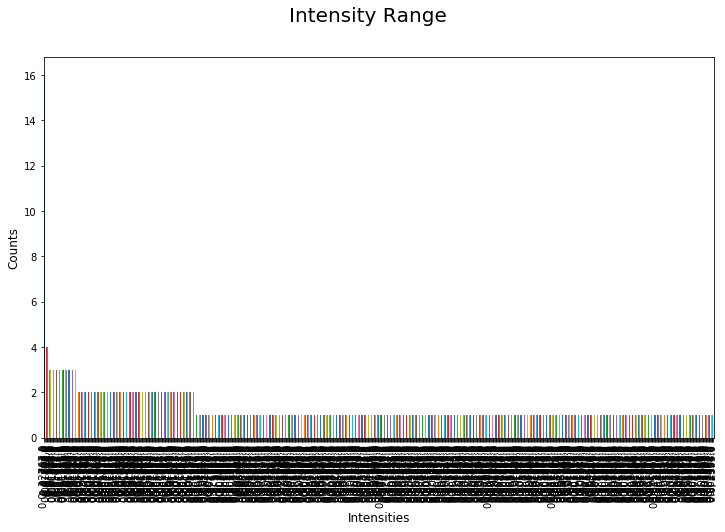

In [171]:
plot_intensities(common_list)

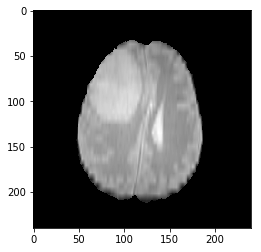

In [167]:
im = sitk.ReadImage(t2_list[1])
im_arr=sitk.GetArrayFromImage(im)

myshow(im_arr, 90)

In [158]:
#lists of paths for all modalities
im1 = sitk.ReadImage(t2_list[0])
im_arr_1 = sitk.GetArrayFromImage(im1)

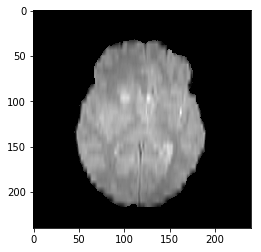

In [159]:
sl_62 = im_arr_1[62,:,:]
#myshow(im_arr_1, 62)
plt.imshow(sl_62,cmap = 'gray')

sl_62 = sitk.GetImageFromArray(sl_62)

In [193]:
type(sl_62)

SimpleITK.SimpleITK.Image

In [195]:
sl_62.GetOrigin()

(0.0, 0.0)

In [204]:
coordinates = [17, 11]

extract = sitk.ExtractImageFilter()
extract.SetSize([32,32])
extract.SetIndex([75-16,100-16])
extracted_image = extract.Execute(sl_62)


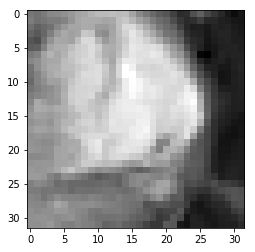

In [205]:
extrcated_rr = sitk.GetArrayFromImage(extracted_image)

plt.imshow(extrcated_rr, cmap = 'gray')

285.0